# Mobile Gaming A/B Testing

## Introduction

This project performs A/B testing on data from the game Cookie Cats, the data is sourced from kaggle. Cookie Cats is a popular puzzle mobile game developed by Tactile Entertainment. As of the time of this project it has over 1 million downloads on Google Play Store with a rating of 4.8. Like similar mobile games the player is time gated at certain stages to encourage them to make in-app purchases or wait until they can progress. 

The data is the result of trials performed by Tactile Entertainment on the first level a player encounters a time gate and their subsequent retention. Players are segmented into *Gate_30* or *Gate_40* - first gate encountered being at level 30 or 40. A/B test will be conducted on the data where the first gate was moved from level 30 to level 40.

## Table of Contents
- <b>1. Data Exploration</b>

## 1. Data Exploration

<b>Imports.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import display, Image

import sys
sys.path.append("../scripts")
import some_functions 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("../input/cookie_cats.csv")

<b>Data Dictionary.

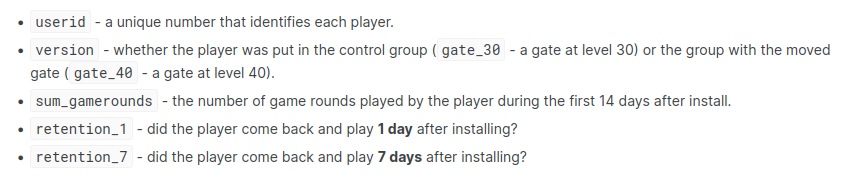

In [3]:
dict_path = "../input/data-dictionary.png"
display(Image(filename=dict_path))

<b>Data head.

In [4]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [5]:
df.shape

(90189, 5)

<b>There are no null values.

In [6]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### <b>User Exploration
<b>The gate groups are fairly balanced user-wise.

In [7]:
print(f"Each entry is a unique user: {df.userid.nunique()} unique users, and {df.shape[0]} entries.")

Each entry is a unique user: 90189 unique users, and 90189 entries.


In [8]:
gate_30_df = df.query("version == 'gate_30'")
print(f"Users in gate_30: {gate_30_df.shape}")

gate_40_df = df.query("version == 'gate_40'")
print(f"Users in gate_40: {gate_40_df.shape}")

Users in gate_30: (44700, 5)
Users in gate_40: (45489, 5)


In [9]:
gate_40_df = df.query("version == 'gate_40'")
gate_40_df.shape

(45489, 5)

<b>Sum Gamerounds exploration.<br>
<b>Is right skewed with outliers.

In [10]:
df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

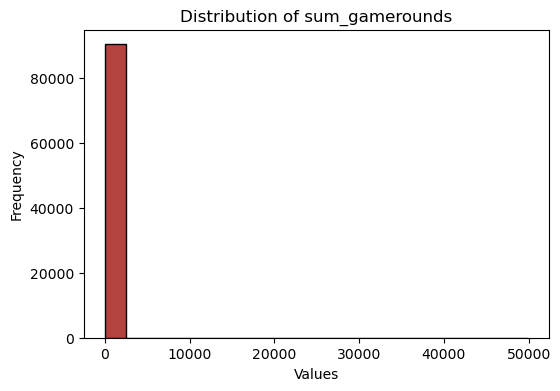

<module 'matplotlib.pyplot' from '/home/ubuntu/miniconda3/envs/cct/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [11]:
some_functions.basic_histo(df.sum_gamerounds,bins=20)

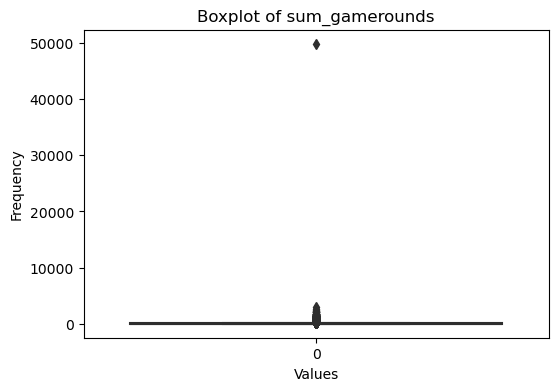

<module 'matplotlib.pyplot' from '/home/ubuntu/miniconda3/envs/cct/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [12]:
some_functions.basic_boxplot(df.sum_gamerounds)

<b>Log transformation helps to visualise it.

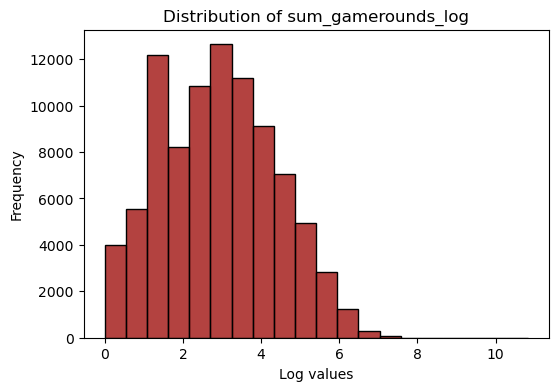

<module 'matplotlib.pyplot' from '/home/ubuntu/miniconda3/envs/cct/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [13]:
df['sum_gamerounds_log'] = np.log(df['sum_gamerounds']+1)
some_functions.basic_histo(df.sum_gamerounds_log, bins=20, values="Log values")

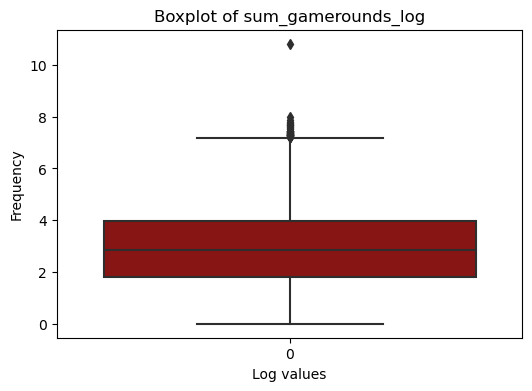

<module 'matplotlib.pyplot' from '/home/ubuntu/miniconda3/envs/cct/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [14]:
some_functions.basic_boxplot(df.sum_gamerounds_log, values="Log values")

### <b>Retention 1 Exploraiton

<b>The one day retention is 44% for the overall data.<br>
<b>The different gates have similar means.

In [15]:
print("Percent of users that play the day after installation:", df['retention_1'].mean())
print("")
display(df['retention_1'].value_counts())

Percent of users that play the day after installation: 0.4452095044850259



retention_1
False    50036
True     40153
Name: count, dtype: int64

In [16]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

<b>These distributions can be expanded on with bootstrapping.<br>
<b>With a small number of samples there isd .

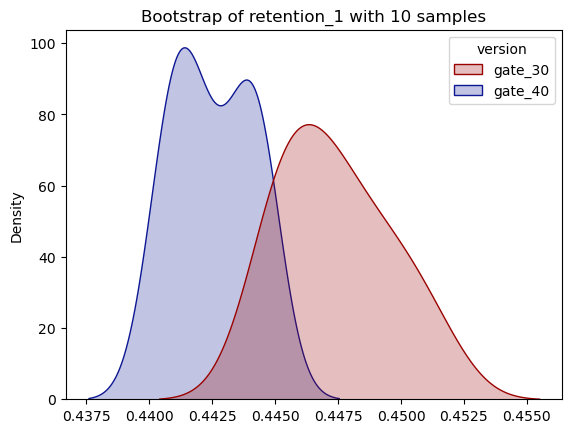

In [18]:
some_functions.basic_bootstrap(df, 10)

<b>With more sampling the distributions look more distinct.

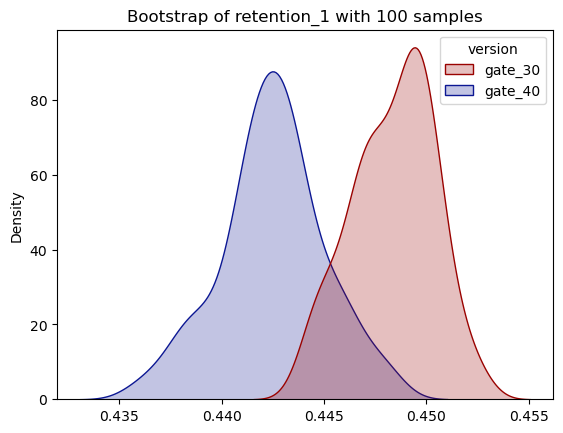

In [22]:
some_functions.basic_bootstrap(df, 100)

### <b>Retention 7 Exploraiton

<b>7 day retention is much lower.

In [23]:
print("Percent of users that play the day after installation:", df['retention_7'].mean())
print("")
display(df['retention_7'].value_counts())

Percent of users that play the day after installation: 0.1860648194347426



retention_7
False    73408
True     16781
Name: count, dtype: int64

In [25]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

<b>This time for 7 day retention and 100 samples greater difference in the means is seen.

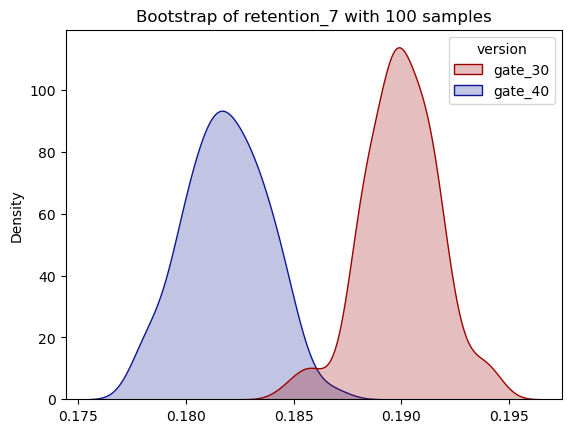

In [31]:
some_functions.basic_bootstrap(df, 100, x_value="retention_7")